In [204]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster
import scipy.io
import scipy.ndimage
from sklearn.model_selection import train_test_split
import pandas as pd

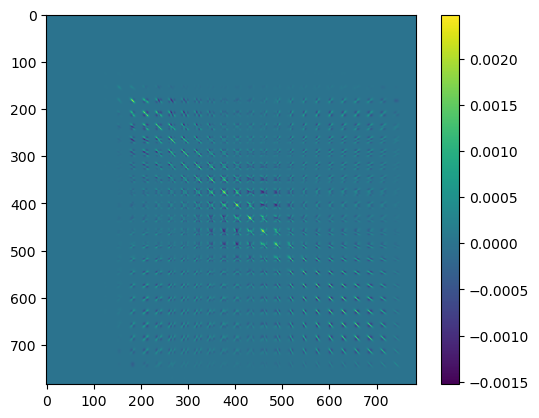

In [258]:
def flatten_mat(data):        
    d = [0] * len(data)
    for x in range(len(data)):
        d[x] = np.array(data[x].flatten())
    return d

#Partition Function
def data_split(data, labels, val_size):
    n = len(data)
    if val_size < 1.0:
        val_size = int(n * val_size)
    train_size = n - val_size
    indices = np.random.permutation(n)
    train_indices, val_indices = indices[:train_size], indices[train_size:]
    return data[train_indices], labels[train_indices], data[val_indices], labels[val_indices]
#Normalize Data
def normalize(data):
    normalized_data = [0] * len(data)
    for x in range(len(data)):
        normalized_data[x] = data[x]/np.linalg.norm(data[x])
    return np.array(normalized_data)

#Load Data
mnist_data = np.load(f"./data/mnist-data-hw3.npz")
mnist_training_data = mnist_data["training_data"]
mnist_training_labels = mnist_data["training_labels"]
mnist_test_data = mnist_data["test_data"]
normalized_mnist_td = normalize(flatten_mat(mnist_training_data))
mnist_test_data = normalize(flatten_mat(mnist_test_data))
    
#part 1
digits = np.unique(mnist_training_labels)
mnist_fitted = {}
covs = []

for digit in digits:
    index = []
    count = 0
    for x in range(len(mnist_training_labels)):
        if (digit == mnist_training_labels[x]):
            index.append(x)
            count = count + 1
    data = []
    
    for i in index:
        data.append(normalized_mnist_td[i])
 
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    mnist_fitted[digit] = (mean, cov)
    covs.append(cov)

plt.imshow(cov)
plt.colorbar()
plt.show()
    



In [259]:
class Model:
    
    def fit(self, data, labels):
        self.classes = np.unique(labels)
        num_samples = data.shape[0]
        self.means = []
        self.covs = []
        self.priors = []
        
        for c in self.classes:
            indices = []
            count = 0

            for x in range(len(labels)):
                if (c == labels[x]):
                    indices.append(x)
                    count = count + 1
            c_data = []
            for i in indices:
                c_data.append(data[i])
            
            self.means.append(np.mean(c_data, axis=0))
            self.covs.append(np.cov(c_data, rowvar=False))
            self.priors.append(count/num_samples)
        
        self.cov_wc = sum(self.covs)
        self.cov_wc /= len(self.classes)
    
    def predictLDA(self, data):
        pred = np.array([(scipy.stats.multivariate_normal.logpdf(data, allow_singular=True, cov=self.cov_wc, mean=self.means[c])
                + np.log(self.priors[c])) for c in self.classes])
        return self.classes[np.argmax(pred, axis=0)]

    def predictQDA(self, data):
        pred = np.array([(scipy.stats.multivariate_normal.logpdf(data, allow_singular=True, cov=self.covs[c], mean=self.means[c])
                + np.log(self.priors[c])) for c in self.classes])
        return self.classes[np.argmax(pred, axis=0)]
    
    def accuracyLDA(self, data, labels):
        pred = self.predictLDA(data)
        return np.sum(pred == labels) / len(labels)
    
    def accuracyQDA(self, data, labels):
        pred = self.predictQDA(data)
        return np.sum(pred == labels) / len(labels)
        
        
            
            
        
    
    


In [264]:
#part 3
mnist_td, mnist_tl, mnist_vd, mnist_vl = data_split(mnist_training_data, mnist_training_labels, 10000)
training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

mnist_td = normalize(flatten_mat(mnist_td))
mnist_vd = normalize(flatten_mat(mnist_vd))
print(mnist_td.shape)

lda = Model()
lda.fit(mnist_td, mnist_tl.flatten())



(50000, 784)


In [261]:
errors1 = []
errors2 = []
for samples in training_sizes:
    lda = Model()
    lda.fit(mnist_td[:samples], mnist_tl[:samples])
    err = 1 - lda.accuracyLDA(mnist_vd, mnist_vl)
    errors1.append(err)
    err = 1 - lda.accuracyQDA(mnist_vd, mnist_vl)
    errors2.append(err)

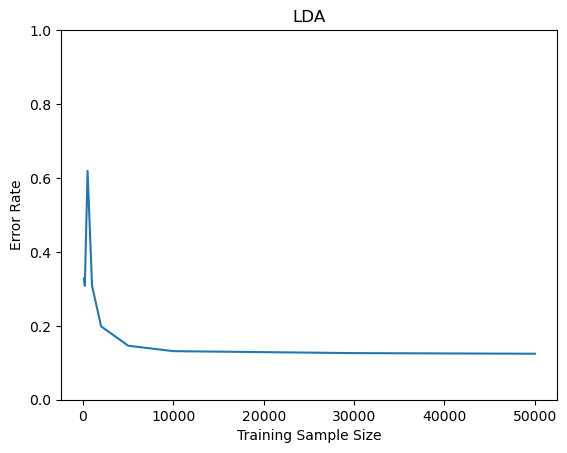

In [262]:
plt.plot(training_sizes, errors1)
plt.xlabel("Training Sample Size")
plt.ylabel("Error Rate")
plt.title("LDA")
plt.ylim((0, 1))
plt.show()

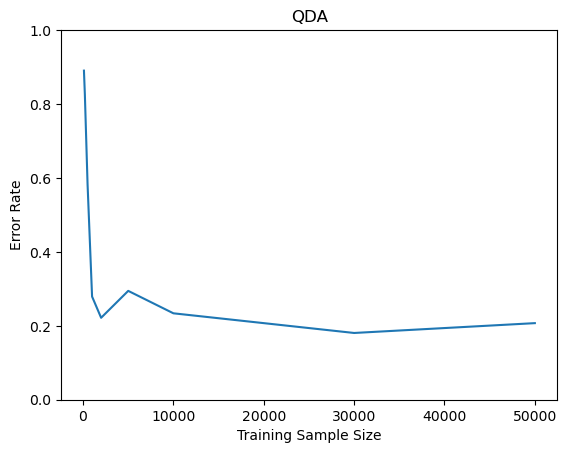

[0.8904, 0.8265, 0.5829, 0.2791, 0.2217, 0.2945, 0.2338, 0.18059999999999998, 0.20720000000000005]


In [256]:
plt.plot(training_sizes, errors2)
plt.xlabel("Training Sample Size")
plt.ylabel("Error Rate")
plt.title("QDA")
plt.ylim((0, 1))
plt.show()
print(errors2)

In [294]:
def split_data_by_class(data, labels):
    d = {}
    classes = np.unique(labels)
    for c in classes:
        indices = []
        labels_new = []

        for x in range(len(labels)):
            if (c == labels[x]):
                indices.append(x)
                
                
        c_data = []
        for i in indices:
            c_data.append(data[i])
            labels_new.append(labels[i])
    
        d[c] = (np.array(c_data), np.array(labels_new))
    return d

split_data = split_data_by_class(mnist_vd, mnist_vl)


training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
errors_c = []
errors_c2 = []
for c in range(10):
    print("Digit: ", c)
    errors = []
    errors2 = []
    for samples in training_sizes:
        lda = Model()
        lda.fit(mnist_td[:samples], mnist_tl[:samples])
        err = 1 - lda.accuracyLDA(split_data[c][0], split_data[c][1])
        errors.append(err)
        err = 1 - lda.accuracyQDA(split_data[c][0], split_data[c][1])
        errors2.append(err)
    errors_c.append(errors)
    errors_c2.append(errors2)
    

    

Digit:  0
Digit:  1
Digit:  2
Digit:  3
Digit:  4
Digit:  5
Digit:  6
Digit:  7
Digit:  8
Digit:  9


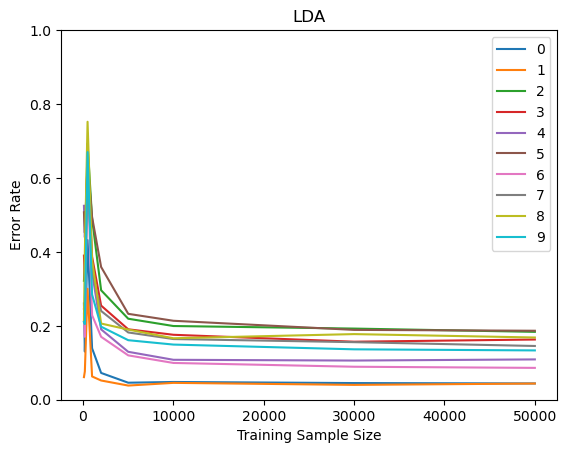

In [295]:
plt.plot(training_sizes, errors_c[0], label = "0")
plt.plot(training_sizes, errors_c[1], label = "1")
plt.plot(training_sizes, errors_c[2], label = "2")
plt.plot(training_sizes, errors_c[3], label = "3")
plt.plot(training_sizes, errors_c[4], label = "4")
plt.plot(training_sizes, errors_c[5], label = "5")
plt.plot(training_sizes, errors_c[6], label = "6")
plt.plot(training_sizes, errors_c[7], label = "7")
plt.plot(training_sizes, errors_c[8], label = "8")
plt.plot(training_sizes, errors_c[9], label = "9")
plt.xlabel("Training Sample Size")
plt.ylabel("Error Rate")
plt.title("LDA")
plt.ylim((0, 1))
plt.legend()
plt.show()

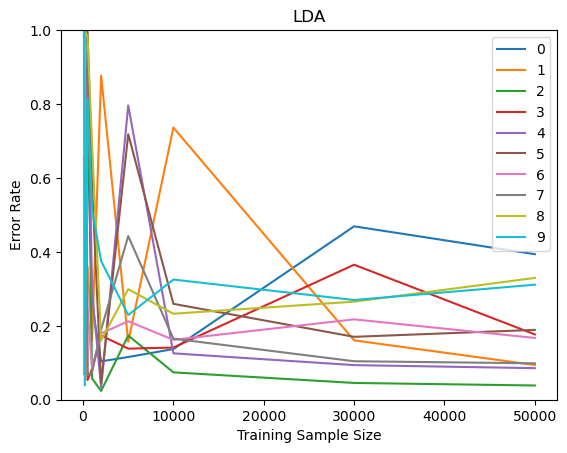

In [296]:
plt.plot(training_sizes, errors_c2[0], label = "0")
plt.plot(training_sizes, errors_c2[1], label = "1")
plt.plot(training_sizes, errors_c2[2], label = "2")
plt.plot(training_sizes, errors_c2[3], label = "3")
plt.plot(training_sizes, errors_c2[4], label = "4")
plt.plot(training_sizes, errors_c2[5], label = "5")
plt.plot(training_sizes, errors_c2[6], label = "6")
plt.plot(training_sizes, errors_c2[7], label = "7")
plt.plot(training_sizes, errors_c2[8], label = "8")
plt.plot(training_sizes, errors_c2[9], label = "9")
plt.xlabel("Training Sample Size")
plt.ylabel("Error Rate")
plt.title("QDA")
plt.ylim((0, 1))
plt.legend()
plt.show()

In [207]:
mnist = Model()
mnist.fit(normalize(flatten_mat(mnist_training_data)), mnist_training_labels)
pred = mnist.predict(flatten_mat(mnist_test_data), "quadratic")

In [208]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission.csv', index_label='Id')

In [219]:
results_to_csv(pred)

In [220]:
spam_data = np.load(f"./data/spam-data-hw3.npz")
spam_training_data = spam_data["training_data"]
spam_training_labels = spam_data["training_labels"]
spam_test_data = spam_data["test_data"]

In [232]:
n = scipy.cluster.vq.whiten(spam_training_data)
spm = Model()
spm.fit(scipy.cluster.vq.whiten(spam_training_data), spam_training_labels)
pred = spm.predict(scipy.cluster.vq.whiten(spam_test_data), "linear")

In [233]:
results_to_csv(pred)